In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd

file_path = "../results/base_results(2).csv"
df_raw = pd.read_csv(file_path)


def load_model_data(df: pd.DataFrame, model_type: str) -> pd.DataFrame:
    model_aliases = {
        "svm": "svm",
        "rf": "rf",
        "random_forest": "rf",
        "lgbm": "lgbm",
        "lightgbm": "lgbm"
    }
    base_type = model_aliases.get(model_type)
    if base_type is None:
        raise ValueError("Unknown model type")

    df_model = df[df["Unnamed: 0"].str.startswith(model_type)].copy()

    if base_type == "svm" or base_type == "rf":
        param_prefix = "static_"
    elif base_type == "lgbm":
        param_prefix = "final_"

    param_cols = [col for col in df_model.columns if col.startswith(param_prefix)]
    other_cols = [col for col in df_model.columns if not col.startswith("static_") and not col.startswith("final_")]

    df_model[param_cols] = df_model[param_cols].ffill()

    return df_model[other_cols + param_cols]

df_rf = load_model_data(df_raw, "random_forest")
df_lgbm = load_model_data(df_raw, "lightgbm")


df_svm = load_model_data(df_raw, "svm")

C:\Users\Mikołaj\AppData\Local\Temp\ipykernel_16564\3909454338.py:38: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_model[param_cols] = df_model[param_cols].ffill()
C:\Users\Mikołaj\AppData\Local\Temp\ipykernel_16564\3909454338.py:38: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_model[param_cols] = df_model[param_cols].ffill()
C:\Users\Mikołaj\AppData\Local\Temp\ipykernel_16564\3909454338.py:38: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(cop

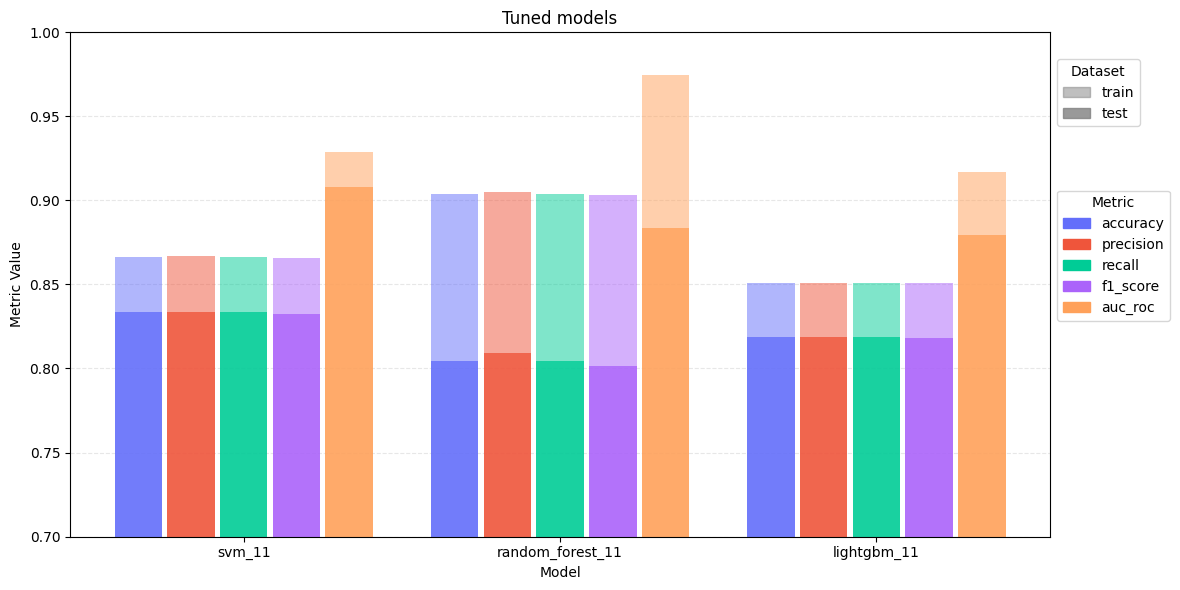

In [ ]:
def plot_metric_bars_by_model(df_svm, df_rf, df_lgbm, models = ['svm_11', 'random_forest_11', 'lightgbm_11'], title="Tuned models"):

    df_svm = df_svm.copy()
    df_rf = df_rf.copy()
    df_lgbm = df_lgbm.copy()

    df_svm["model_name"] = models[0]
    df_rf["model_name"] = models[1]
    df_lgbm["model_name"] = models[2]

    df_all = pd.concat([df_svm, df_rf, df_lgbm], ignore_index=True)

    metrics = ['accuracy', 'precision', 'recall', 'f1_score', 'auc_roc']
    colors = {
        'accuracy': '#636EFA',
        'precision': '#EF553B',
        'recall': '#00CC96',
        'f1_score': '#AB63FA',
        'auc_roc': '#FFA15A'
    }

    melted_data = []
    for _, row in df_all.iterrows():
        model = row['model_name']
        for metric in metrics:
            for ds in ['train', 'test']:
                key = f'{ds}_{metric}'
                if key in row and pd.notna(row[key]):
                    melted_data.append({
                        'model': model,
                        'metric': metric,
                        'dataset': ds,
                        'value': row[key]
                    })

    df_plot = pd.DataFrame(melted_data)

    unique_models = df_plot['model'].unique()
    n_metrics = len(metrics)
    bar_width = 0.9
    spacing = 1.0

    fig, ax = plt.subplots(figsize=(14, 6))

    for i, model in enumerate(unique_models):
        for j, metric in enumerate(metrics):
            base_x = i * (n_metrics + spacing)
            x = base_x + j
            df_subset = df_plot[(df_plot['model'] == model) & (df_plot['metric'] == metric)]

            for ds in ['train', 'test']:
                val = df_subset[df_subset['dataset'] == ds]['value'].values
                if val.size > 0:
                    alpha = 0.5 if ds == 'train' else 0.8
                    ax.bar(x, val[0], color=colors[metric], alpha=alpha, width=bar_width)

    ax.set_xticks([(i * (n_metrics + spacing)) + (n_metrics - 1) / 2 for i in range(len(unique_models))])
    ax.set_xticklabels(unique_models)
    ax.set_xlabel("Model")
    ax.set_ylabel("Metric Value")
    ax.set_title(title)
    ax.yaxis.grid(True, linestyle='--', alpha=0.3)
    ax.set_axisbelow(True)
    ax.set_ylim(0.7, 1.0)

    metric_handles = [plt.Rectangle((0, 0), 1, 1, color=colors[m], alpha=1.0) for m in metrics]
    metric_labels = metrics

    transparency_handles = [
        plt.Rectangle((0, 0), 1, 1, color='gray', alpha=0.5),
        plt.Rectangle((0, 0), 1, 1, color='gray', alpha=0.8)
    ]
    transparency_labels = ["train", "test"]

    legend2 = ax.legend(transparency_handles, transparency_labels, title="Dataset", loc='lower left', bbox_to_anchor=(1, 0.80))
    legend1 = ax.legend(metric_handles, metric_labels, title="Metric", loc='upper left', bbox_to_anchor=(1, 0.7))
    ax.add_artist(legend2)

    plt.tight_layout(rect=[0, 0, 0.85, 1])
    plt.show()

plot_metric_bars_by_model(df_svm, df_rf, df_lgbm)